# Clustering RNA sequences to identify cancer types

In this assignment, we will use clustering algorithms on RNA sequence data to identify cancer types.
Since the [whole data](https://www.synapse.org/#!Synapse:syn4301332) (from [Cancer Genome Atlas Pan-Cancer project](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3919969/)) is very big, we will use a [subset data from UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#). The subset data contains only 5 labels; BRCA, KIRC, COAD, LUAD and PRAD. The meanings of those labels are as below.

|Abbreviation|Cancer|
|:----:|:-------:|
|LUSC|Lung squamous cell carcinoma |
|READ |Rectum adenocarcinoma |
|GBM |Glioblastoma multiforme|
|BLCA |Bladder Urothelial Carcinoma|
|UCEC |Uterine Corpus Endometrioid Carcinoma|
|COAD |Colon adenocarcinoma|
|OV |Ovarian serous cystadenocarcinoma|
|LAML |Acute Myeloid Leukemia|
|HNSC |Head and Neck squamous cell carcinoma|
|LUAD |Lung adenocarcinoma|
|BRCA |Breast invasive carcinoma|
|KIRC |Kidney renal clear cell carcinoma|

Although we can use the data for supervised learning model training, we will not use these labels for training, but use them for evaluation.

In [1]:
%run data_loader.py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import time

Data loaded


In [2]:
# Read data. Do not change the variable names (data, label)
data = pd.read_csv('data/data.csv')
label = pd.read_csv('data/labels.csv')
data=data.drop('Unnamed: 0',axis=1)
label=label.drop('Unnamed: 0',axis=1)

### A. Perform basic data inspection or EDA on the pandas dataframe.
<style>
    r {color: Red}
    b {color: rgb(55, 57, 196)}
</style>
- How many observations? <b>*801*</b>
- How many features? <b>*20531*</b>

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5 MB


- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What do those numbers mean? (We do not expect students to know or figure out the meanings, but if you do know by chance, feel free to discuss them with the class on the discussion board.) <br>

Text(0.5, 1.0, 'Min histogram')

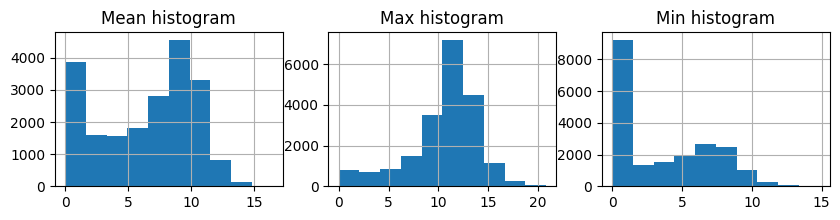

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
fig.set_size_inches(10,2)
data.mean().hist(ax=ax1)
data.max().hist(ax=ax2)
data.min().hist(ax=ax3)
ax1.set_title("Mean histogram")
ax2.set_title("Max histogram")
ax3.set_title("Min histogram")

<style>
    r {color: Red}
    b {color: rgb(55, 57, 196)}
</style>
- If we were to train a "supervised" learning model, how would you deal with such large feature dimension?  <b>I will select the most relevant features and train on them</b>
- Even after feature dimension reduction, still the number of useful features may be enormous. How it would impact performance or runtime of certain supervised learning algorithms? Which algorithms would suffer from high dimension features than others and why? 
- How it would impact performance or runtime of an unsupervised learning algorithm? <b>Knearest is one of the most affected by quantity of data. Some algorithms will increase the training time, but for example knearst will suffer overfitting</b>
- Draw histograms of mean, max and min values in each feature. You may see numbers around 0-20. What those numbers mean? (We do not expect you to know or figure out the meanings, but if you do know by chance, feel free to discuss.) <br> <br>

### B. Build a hierarchical clustering model
Let's build a model using hierarchical clustering. Hierarchical clustering module is available from `sklearn.cluster.AgglomerativeClustering`. You can choose linkage type and metric. Please check its documentation for more details.

**a) Number of clusters vs distance threshold**
Oftentimes hierarchical clustering does not need to know the number of clusters in advance. Instead, one needs to choose threshold distance/similarity to cut the dendrogram later. The AgglomerativeClustering module lets you specify either the number of clusters (n_clusters) or the threshold (distance_threshold). Based on our data, which should we choose to set to which value and why? <br> <br>

#### b) Guess which metric?
Can you guess which metric to use (distance-based vs. similarity-based) and why? 
This question is not graded, but we encourage you to share your thoughts with the class. See the ungraded discussion prompt for this week's material. 

#### c) Build a model
Build a model using n_clusters=5 option. Choose any metric and linkage type at first. Display the clustering result labels (you can just print out the result).

In [5]:
# build a model using n_clusters=5 option
model= AgglomerativeClustering(n_clusters=5).fit(data)
# your code here

#### d) Label permuation
In clustering, the labels get assigned randomly, so the label numbering won't match the ground truth necessarily. Write a function below to find best matching label ordering based on the accuracy. 

In [6]:
import itertools

def label_permute_compare(ytdf:pd.DataFrame,yp:np.ndarray,n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    permuted_label = None
    accuracy = 0
    unique_labels = ytdf["Class"].unique()
    unique_predicted_labels = np.unique(yp)
    
    
    index_pairs = itertools.permutations(range(len(unique_predicted_labels)), len(unique_labels))
    

    for combination in index_pairs:
        processed_yp = [next((t[0] for t in zip(unique_labels,combination) if t[1] == x), x) for x in yp]
        test_acc = accuracy_score(ytdf["Class"].to_list(),processed_yp)
        if (test_acc>accuracy):
            permuted_label = combination
            accuracy = test_acc
            
    return permuted_label, accuracy
# your code here

In [7]:
labelorder, acc = label_permute_compare(label, model.labels_)
print(labelorder, acc)

(2, 3, 0, 1, 4) 0.9950062421972534


#### e) Check confusion matrix
Use sklearn's confusion matrix and display the results. 

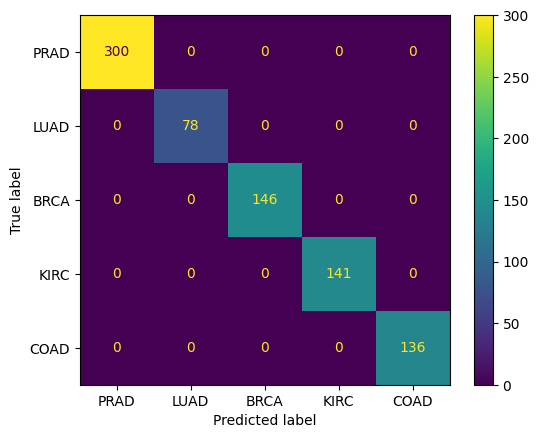

In [9]:
processed_yp = [next((t[0] for t in zip(label,labelorder) if t[1] == x), x) for x in label["Class"]]
labels = [next((t[0] for t in zip(label,labelorder) if t[1] == x), x) for x in label["Class"].unique()]
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(label["Class"].to_list(),processed_yp), display_labels=labels).plot()

#### f) Change linkage method and distance metric. Which ones lead the best performance? Print out the accuracy and confusion matrix for the best model.

### C. What about k-means clustering?
Can we apply kmeans clustering on this data? Which clustering methods give a better performance? Is kmeans faster or slower?